# 🔧 Preprocessing & Feature Engineering for Churn Prediction
## (نسخه جامع با Rolling Window Split)

**هدف:** آماده‌سازی داده و ساخت فیچرهای معنادار بدون Data Leakage

**ویژگی‌های این پروژه:**
- Q-Commerce / Grocery Delivery Dataset
- فوکوس روی Delivery Experience و Customer Satisfaction
- بدون Monetary value (RF به جای RFM)
- ۵ سگمنت با تعریف Churn مختص هر سگمنت

**نکات کلیدی:**
- ✅ Rolling Window Split برای جلوگیری از Data Leakage
- ✅ فیچرها فقط از Observation Window ساخته میشن
- ✅ Label از Prediction Window میاد

```
Timeline:
|======= Observation Window =======|==== Prediction Window ====|
|  فیچرها از این بازه ساخته میشن    |   Label از اینجا میاد      |
|                                  |  (آیا کاربر برگشت یا نه؟)  |
                                   ^
                              Cutoff Date
```

**بخش‌ها:**
1. Data Loading & Initial Cleaning
2. Simple NLP Features for Comments
3. Missing Value Handling
4. Outlier Removal
5. Rolling Window Split Setup
6. Feature Engineering Function (Comprehensive)
7. Build Train/Test Sets
8. Save Processed Data

---

## 0️⃣ Setup & Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import jdatetime
from scipy import stats
import re
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('✅ Libraries loaded!')

✅ Libraries loaded!


In [2]:
# =============================================================================
# CONFIGURATION
# =============================================================================

DATA_DIR = '../data'
OUTPUT_DIR = '../data/processed'

# Outlier threshold
EXTREME_ORDER_THRESHOLD = 200  # Users with >200 orders are likely B2B/bots

# Segment-specific churn thresholds (days)
CHURN_THRESHOLDS = {
    '1 Order': 30,
    '2-4 Orders': 30,
    '5-10 Orders': 30,
    '11-30 Orders': 16,
    '30+ Orders': 14
}

# =============================================================================
# ROLLING WINDOW CONFIGURATION
# =============================================================================
OBSERVATION_WINDOW_DAYS = 90   # فیچرها از این بازه ساخته میشن
PREDICTION_WINDOW_DAYS = 30    # این بازه برای مشاهده churn
GAP_DAYS = 0                   # فاصله بین observation و prediction

print('✅ Configuration loaded!')
print(f'''
📋 Settings:
   Extreme order threshold: {EXTREME_ORDER_THRESHOLD}
   Observation Window: {OBSERVATION_WINDOW_DAYS} days
   Prediction Window:  {PREDICTION_WINDOW_DAYS} days
''')

✅ Configuration loaded!

📋 Settings:
   Extreme order threshold: 200
   Observation Window: 90 days
   Prediction Window:  30 days



In [3]:
# Helper functions
def to_jalali(date):
    """Convert Gregorian date to Jalali string."""
    if pd.isna(date):
        return None
    if isinstance(date, str):
        date = pd.to_datetime(date)
    j_date = jdatetime.date.fromgregorian(date=date.date() if hasattr(date, 'date') else date)
    return j_date.strftime('%Y/%m/%d')

def to_jalali_year_month(date):
    """Get Jalali year-month for grouping."""
    if pd.isna(date):
        return None
    if isinstance(date, str):
        date = pd.to_datetime(date)
    j_date = jdatetime.date.fromgregorian(date=date.date() if hasattr(date, 'date') else date)
    return f"{j_date.year}-{j_date.month:02d}"

def assign_frequency_segment(order_count):
    """Assign user to frequency segment."""
    if order_count == 1:
        return '1 Order'
    elif order_count <= 4:
        return '2-4 Orders'
    elif order_count <= 10:
        return '5-10 Orders'
    elif order_count <= 30:
        return '11-30 Orders'
    else:
        return '30+ Orders'

print('✅ Helper functions ready!')

✅ Helper functions ready!


---
## 1️⃣ Data Loading & Initial Cleaning

In [4]:
print('📂 Loading data...')

orders_raw = pd.read_csv(f'{DATA_DIR}/orders.csv')
crm_raw = pd.read_csv(f'{DATA_DIR}/crm.csv')
comments_raw = pd.read_csv(f'{DATA_DIR}/order_comments.csv')

print(f'\n📊 Raw Data Sizes:')
print(f'   orders:   {len(orders_raw):>10,} rows')
print(f'   crm:      {len(crm_raw):>10,} rows')
print(f'   comments: {len(comments_raw):>10,} rows')

📂 Loading data...

📊 Raw Data Sizes:
   orders:    2,720,059 rows
   crm:       2,720,059 rows
   comments:     93,855 rows


In [5]:
# Convert dates
orders_raw['order_date'] = pd.to_datetime(orders_raw['order_date'])

# Get date range
MIN_DATE = orders_raw['order_date'].min()
MAX_DATE = orders_raw['order_date'].max()
DATE_RANGE = (MAX_DATE - MIN_DATE).days

print(f'\n📅 Date Range:')
print(f'   Start: {to_jalali(MIN_DATE)} ({MIN_DATE.date()})')
print(f'   End:   {to_jalali(MAX_DATE)} ({MAX_DATE.date()})')
print(f'   Span:  {DATE_RANGE} days')


📅 Date Range:
   Start: 1403/12/26 (2025-03-16)
   End:   1404/06/21 (2025-09-12)
   Span:  180 days


### 1.1 Clean Comments Data

دو مشکل داریم:
1. order_id های تکراری
2. order_id هایی که در orders وجود ندارن (orphans)

In [6]:
print('='*70)
print('🧹 Cleaning Comments Data')
print('='*70)

original_comments = len(comments_raw)
print(f'\nOriginal comments: {original_comments:,}')

# Step 1: Remove duplicate order_ids (keep first)
duplicates_before = comments_raw['order_id'].duplicated().sum()
comments_clean = comments_raw.drop_duplicates(subset=['order_id'], keep='first')
print(f'Duplicate order_ids removed: {duplicates_before:,}')

# Step 2: Remove orphan order_ids (not in orders)
valid_order_ids = set(orders_raw['order_id'].unique())
orphans_before = (~comments_clean['order_id'].isin(valid_order_ids)).sum()
comments_clean = comments_clean[comments_clean['order_id'].isin(valid_order_ids)]
print(f'Orphan order_ids removed: {orphans_before:,}')

print(f'\n✅ Final comments: {len(comments_clean):,} ({len(comments_clean)/original_comments*100:.1f}% retained)')

🧹 Cleaning Comments Data

Original comments: 93,855
Duplicate order_ids removed: 6,237
Orphan order_ids removed: 5,037

✅ Final comments: 82,581 (88.0% retained)


---
## 2️⃣ Simple NLP Features for Comments

فیچرهای ساده بدون Sentiment Analysis (چون فقط ~3% سفارشات کامنت دارن)

In [7]:
print('='*70)
print('📝 Building Simple Comment Features')
print('='*70)

comments_clean = comments_clean.copy()

# Text length
comments_clean['comment_length'] = comments_clean['description'].fillna('').str.len()
comments_clean['comment_word_count'] = comments_clean['description'].fillna('').str.split().str.len()

# Has emoji
emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"
    u"\U0001F300-\U0001F5FF"
    u"\U0001F680-\U0001F6FF"
    u"\U0001F1E0-\U0001F1FF"
    u"\U00002702-\U000027B0"
    u"\U0001F900-\U0001F9FF"
    "]+", flags=re.UNICODE)

comments_clean['has_emoji'] = comments_clean['description'].fillna('').apply(
    lambda x: 1 if emoji_pattern.search(x) else 0
)

print(f'\n📊 Comment Statistics:')
print(f'   Average length: {comments_clean["comment_length"].mean():.1f} chars')
print(f'   Average words: {comments_clean["comment_word_count"].mean():.1f}')
print(f'   Has emoji: {comments_clean["has_emoji"].mean()*100:.1f}%')

📝 Building Simple Comment Features

📊 Comment Statistics:
   Average length: 74.8 chars
   Average words: 15.3
   Has emoji: 2.7%


In [8]:
# Keyword-based features (Rule-Based, No ML needed)
print('\n📝 Keyword-Based Features:')

KEYWORD_PATTERNS = {
    # Positive signals
    'mentions_thanks': r'(ممنون|تشکر|مرسی|سپاس|عالی|خوب|راضی)',
    
    # Negative signals
    'mentions_problem': r'(مشکل|ایراد|بد|ضعیف|ناراضی|افتضاح)',
    'mentions_late': r'(دیر|تاخیر|تأخیر|نرسید|دیرکرد)',
    'mentions_wrong_item': r'(اشتباه|غلط|نخواستم|عوض)',
    'mentions_quality_issue': r'(خراب|فاسد|کیفیت|تاریخ.?مصرف|بو)',
    'mentions_packaging': r'(بسته.?بندی|شکست|له|ریخت)',
    
    # Churn signals (very important!)
    'mentions_last_time': r'(آخرین.?بار|دیگه|نمی.?خر|نمیخر)'
}

for feature_name, pattern in KEYWORD_PATTERNS.items():
    comments_clean[feature_name] = comments_clean['description'].fillna('').str.contains(
        pattern, regex=True, case=False, na=False
    ).astype(int)
    pct = comments_clean[feature_name].mean() * 100
    print(f'   {feature_name}: {pct:.1f}%')


📝 Keyword-Based Features:
   mentions_thanks: 32.5%
   mentions_problem: 12.9%
   mentions_late: 7.1%
   mentions_wrong_item: 2.9%
   mentions_quality_issue: 46.2%
   mentions_packaging: 10.1%
   mentions_last_time: 3.6%


In [9]:
# Prepare comment features for merging
comment_feature_cols = ['order_id', 'comment_length', 'comment_word_count', 'has_emoji',
                        'mentions_thanks', 'mentions_problem', 'mentions_late',
                        'mentions_wrong_item', 'mentions_quality_issue', 'mentions_packaging',
                        'mentions_last_time']

comment_features_order_level = comments_clean[comment_feature_cols].copy()
print(f'\n✅ Comment features prepared for {len(comment_features_order_level):,} orders')


✅ Comment features prepared for 82,581 orders


---
## 3️⃣ Merge & Preprocess Data

In [10]:
print('='*70)
print('🔗 Merging Datasets')
print('='*70)

# Merge orders with CRM
crm_cols = ['order_id', 'crm_delivery_request_count', 'crm_fake_delivery_request_count',
            'rate_to_shop', 'rate_to_courier']
orders_df = orders_raw.merge(crm_raw[crm_cols], on='order_id', how='left')

# Merge with comment features
orders_df = orders_df.merge(comment_features_order_level, on='order_id', how='left')

# Create has_comment flag
orders_df['has_comment'] = orders_df['comment_length'].notna().astype(int)

# Fill NaN for orders without comments
comment_cols = ['comment_length', 'comment_word_count', 'has_emoji',
                'mentions_thanks', 'mentions_problem', 'mentions_late',
                'mentions_wrong_item', 'mentions_quality_issue', 'mentions_packaging',
                'mentions_last_time']
for col in comment_cols:
    orders_df[col] = orders_df[col].fillna(0).astype(int)

print(f'✅ Merged dataset: {len(orders_df):,} orders')
print(f'   Orders with comments: {orders_df["has_comment"].sum():,} ({orders_df["has_comment"].mean()*100:.2f}%)')

🔗 Merging Datasets
✅ Merged dataset: 2,720,059 orders
   Orders with comments: 82,581 (3.04%)


### 3.1 Handle Missing Values

In [11]:
print('='*70)
print('🔧 Handling Missing Values')
print('='*70)

# Ratings: Zero + Indicator approach
print('\n📊 Ratings (Zero + Indicator):')
orders_df['has_rated_shop'] = orders_df['rate_to_shop'].notna().astype(int)
orders_df['rate_to_shop_filled'] = orders_df['rate_to_shop'].fillna(0)
print(f'   has_rated_shop: {orders_df["has_rated_shop"].mean()*100:.1f}% = 1')

orders_df['has_rated_courier'] = orders_df['rate_to_courier'].notna().astype(int)
orders_df['rate_to_courier_filled'] = orders_df['rate_to_courier'].fillna(0)
print(f'   has_rated_courier: {orders_df["has_rated_courier"].mean()*100:.1f}% = 1')

# is_otd: Separate flags for each category
print('\n📊 is_otd (Separate Flags):')
orders_df['is_otd_ontime'] = (orders_df['is_otd'] == 1).astype(int)
orders_df['is_otd_late'] = (orders_df['is_otd'] == 0).astype(int)
orders_df['is_otd_unknown'] = (orders_df['is_otd'] == -1).astype(int)
print(f'   is_otd_ontime:  {orders_df["is_otd_ontime"].mean()*100:.1f}%')
print(f'   is_otd_late:    {orders_df["is_otd_late"].mean()*100:.1f}%')
print(f'   is_otd_unknown: {orders_df["is_otd_unknown"].mean()*100:.1f}%')

# delivery_status: Fill and create flags
print('\n📊 delivery_status:')
orders_df['delivery_status'] = orders_df['delivery_status'].fillna('unknown')
orders_df['is_delivered'] = (orders_df['delivery_status'] == 'delivered').astype(int)
orders_df['is_cancelled'] = orders_df['delivery_status'].str.contains('cancel', case=False, na=False).astype(int)
print(f'   is_delivered: {orders_df["is_delivered"].mean()*100:.1f}%')
print(f'   is_cancelled: {orders_df["is_cancelled"].mean()*100:.1f}%')

🔧 Handling Missing Values

📊 Ratings (Zero + Indicator):
   has_rated_shop: 41.4% = 1
   has_rated_courier: 26.3% = 1

📊 is_otd (Separate Flags):
   is_otd_ontime:  74.2%
   is_otd_late:    19.7%
   is_otd_unknown: 6.1%

📊 delivery_status:
   is_delivered: 95.5%
   is_cancelled: 2.8%


---
## 4️⃣ Remove Extreme Users (Outliers)

In [12]:
print('='*70)
print('🚨 Outlier Analysis & Removal')
print('='*70)

orders_per_user = orders_df.groupby('user_id').size().reset_index(name='order_count')

print('\nOrder count statistics (before removal):')
print(orders_per_user['order_count'].describe())

# Identify extreme users
extreme_users = orders_per_user[orders_per_user['order_count'] > EXTREME_ORDER_THRESHOLD]['user_id']
print(f'\n🚨 Extreme users (>{EXTREME_ORDER_THRESHOLD} orders): {len(extreme_users):,}')

🚨 Outlier Analysis & Removal

Order count statistics (before removal):
count   375998.000
mean         7.234
std         40.306
min          1.000
25%          1.000
50%          2.000
75%          7.000
max      23079.000
Name: order_count, dtype: float64

🚨 Extreme users (>200 orders): 110


In [13]:
# Show extreme users
if len(extreme_users) > 0:
    extreme_stats = orders_per_user[orders_per_user['user_id'].isin(extreme_users)].sort_values('order_count', ascending=False)
    print('\nTop 10 extreme users:')
    display(extreme_stats.head(10))


Top 10 extreme users:


,user_id,order_count
131192,20524543,23079
228453,33115912,971
52990,547202,791
190464,31060336,696
207178,31282871,656
315075,33829795,609
225837,33033498,595
86033,1674703,585
197348,31128401,493
108421,3254127,455


In [14]:
# Remove extreme users
orders_before = len(orders_df)
users_before = orders_df['user_id'].nunique()

orders_df = orders_df[~orders_df['user_id'].isin(extreme_users)]

orders_after = len(orders_df)
users_after = orders_df['user_id'].nunique()

print(f'\n✅ Removed extreme users:')
print(f'   Orders: {orders_before:,} → {orders_after:,} ({(orders_before-orders_after):,} removed)')
print(f'   Users:  {users_before:,} → {users_after:,} ({len(extreme_users):,} removed)')


✅ Removed extreme users:
   Orders: 2,720,059 → 2,666,013 (54,046 removed)
   Users:  375,998 → 375,888 (110 removed)


---
## 5️⃣ Rolling Window Split Setup

In [15]:
print('='*70)
print('⏰ Rolling Window Split Setup')
print('='*70)

# Calculate valid cutoff range
earliest_cutoff = MIN_DATE + timedelta(days=OBSERVATION_WINDOW_DAYS)
latest_cutoff = MAX_DATE - timedelta(days=PREDICTION_WINDOW_DAYS)

print(f'''
📅 Date Range: {to_jalali(MIN_DATE)} → {to_jalali(MAX_DATE)}

📋 Valid Cutoff Range:
   Earliest: {to_jalali(earliest_cutoff)} (need {OBSERVATION_WINDOW_DAYS}d before)
   Latest:   {to_jalali(latest_cutoff)} (need {PREDICTION_WINDOW_DAYS}d after)
''')

# Choose cutoff dates
valid_range = (latest_cutoff - earliest_cutoff).days

TRAIN_CUTOFF = earliest_cutoff + timedelta(days=int(valid_range * 0.5))
TEST_CUTOFF = earliest_cutoff + timedelta(days=int(valid_range * 0.8))

print(f'''
🎯 Selected Cutoff Dates:
   Train Cutoff: {to_jalali(TRAIN_CUTOFF)} ({TRAIN_CUTOFF.date()})
   Test Cutoff:  {to_jalali(TEST_CUTOFF)} ({TEST_CUTOFF.date()})
''')

⏰ Rolling Window Split Setup

📅 Date Range: 1403/12/26 → 1404/06/21

📋 Valid Cutoff Range:
   Earliest: 1404/03/24 (need 90d before)
   Latest:   1404/05/22 (need 30d after)


🎯 Selected Cutoff Dates:
   Train Cutoff: 1404/04/23 (2025-07-14)
   Test Cutoff:  1404/05/10 (2025-08-01)



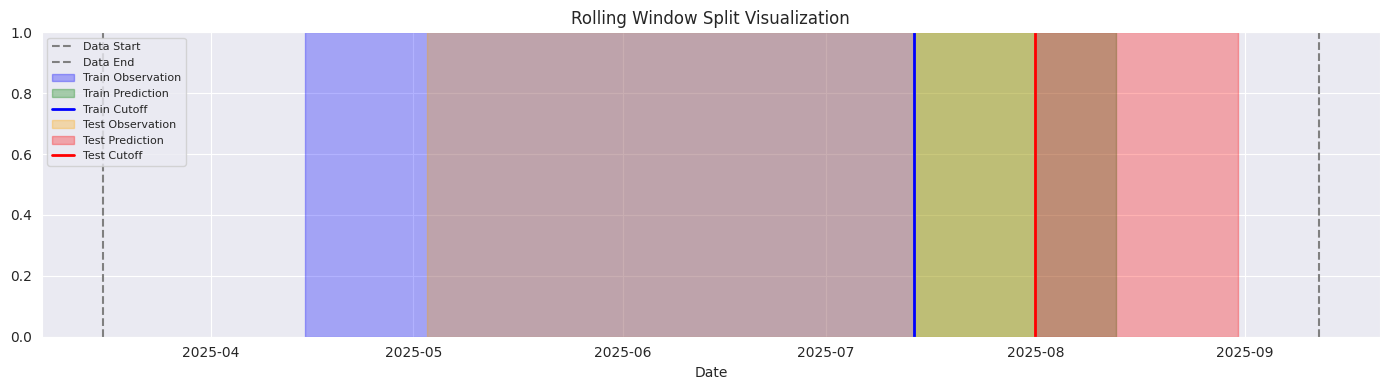

In [16]:
# Visualize the split
fig, ax = plt.subplots(figsize=(14, 4))

ax.axvline(x=MIN_DATE, color='gray', linestyle='--', label='Data Start')
ax.axvline(x=MAX_DATE, color='gray', linestyle='--', label='Data End')

# Train window
train_obs_start = TRAIN_CUTOFF - timedelta(days=OBSERVATION_WINDOW_DAYS)
train_pred_end = TRAIN_CUTOFF + timedelta(days=PREDICTION_WINDOW_DAYS)
ax.axvspan(train_obs_start, TRAIN_CUTOFF, alpha=0.3, color='blue', label='Train Observation')
ax.axvspan(TRAIN_CUTOFF, train_pred_end, alpha=0.3, color='green', label='Train Prediction')
ax.axvline(x=TRAIN_CUTOFF, color='blue', linewidth=2, label='Train Cutoff')

# Test window
test_obs_start = TEST_CUTOFF - timedelta(days=OBSERVATION_WINDOW_DAYS)
test_pred_end = TEST_CUTOFF + timedelta(days=PREDICTION_WINDOW_DAYS)
ax.axvspan(test_obs_start, TEST_CUTOFF, alpha=0.3, color='orange', label='Test Observation')
ax.axvspan(TEST_CUTOFF, test_pred_end, alpha=0.3, color='red', label='Test Prediction')
ax.axvline(x=TEST_CUTOFF, color='red', linewidth=2, label='Test Cutoff')

ax.set_xlabel('Date')
ax.set_title('Rolling Window Split Visualization')
ax.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

---
## 6️⃣ Comprehensive Feature Engineering Function

این تابع فیچرها رو فقط از سفارشات **قبل از cutoff** می‌سازه

**شامل:**
- RF Features (Recency-Frequency)
- Delivery Quality Features + Advanced OTD
- CRM/Support Features
- Rating/Satisfaction Features + Low Rating Indicators
- Comment Features (NLP)
- First/Last Order Features
- Temporal Features
- Interaction Features

In [17]:
def build_features_for_cutoff(orders_df, cutoff_date, observation_window_days=90):
    """
    Build comprehensive user features using only data BEFORE cutoff_date.
    Prevents data leakage by ensuring features don't use future information.
    """
    
    # Filter to observation window only
    obs_start = cutoff_date - timedelta(days=observation_window_days)
    obs_df = orders_df[
        (orders_df['order_date'] >= obs_start) & 
        (orders_df['order_date'] < cutoff_date)
    ].copy()
    
    # Get ALL historical orders before cutoff (for lifetime features)
    historical_df = orders_df[orders_df['order_date'] < cutoff_date].copy()
    
    # Sort and calculate sequential features
    historical_df = historical_df.sort_values(['user_id', 'order_date'])
    historical_df['order_seq'] = historical_df.groupby('user_id').cumcount() + 1
    historical_df['prev_order_date'] = historical_df.groupby('user_id')['order_date'].shift(1)
    historical_df['days_between'] = (historical_df['order_date'] - historical_df['prev_order_date']).dt.days
    
    # Get users who were active in observation window
    active_users = obs_df['user_id'].unique()
    historical_df = historical_df[historical_df['user_id'].isin(active_users)]
    
    # =========================================================================
    # 1. RF FEATURES (Recency-Frequency)
    # =========================================================================
    rf_features = historical_df.groupby('user_id').agg(
        total_orders=('order_id', 'count'),
        first_order_date=('order_date', 'min'),
        last_order_date=('order_date', 'max'),
        avg_days_between_orders=('days_between', 'mean'),
        std_days_between_orders=('days_between', 'std'),
        min_order_interval=('days_between', 'min'),
        max_order_interval=('days_between', 'max'),
        median_order_interval=('days_between', 'median')
    ).reset_index()
    
    rf_features['recency'] = (cutoff_date - rf_features['last_order_date']).dt.days
    rf_features['tenure_days'] = (rf_features['last_order_date'] - rf_features['first_order_date']).dt.days
    rf_features['cv_order_interval'] = rf_features['std_days_between_orders'] / (rf_features['avg_days_between_orders'] + 1)
    rf_features['orders_per_month'] = rf_features['total_orders'] / ((rf_features['tenure_days'] + 1) / 30)
    rf_features['recency_tenure_ratio'] = rf_features['recency'] / (rf_features['tenure_days'] + 1)
    
    # =========================================================================
    # 2. DELIVERY FEATURES (Basic)
    # =========================================================================
    delivery_features = historical_df.groupby('user_id').agg(
        otd_orders=('is_otd_ontime', 'sum'),
        late_orders=('is_otd_late', 'sum'),
        unknown_otd_orders=('is_otd_unknown', 'sum'),
        delivered_orders=('is_delivered', 'sum'),
        cancelled_orders=('is_cancelled', 'sum')
    ).reset_index()
    
    delivery_features = delivery_features.merge(rf_features[['user_id', 'total_orders']], on='user_id')
    delivery_features['otd_rate'] = delivery_features['otd_orders'] / delivery_features['total_orders']
    delivery_features['late_rate'] = delivery_features['late_orders'] / delivery_features['total_orders']
    delivery_features['unknown_otd_rate'] = delivery_features['unknown_otd_orders'] / delivery_features['total_orders']
    delivery_features['delivery_success_rate'] = delivery_features['delivered_orders'] / delivery_features['total_orders']
    delivery_features['cancellation_rate'] = delivery_features['cancelled_orders'] / delivery_features['total_orders']
    delivery_features = delivery_features.drop(columns=['total_orders'])
    
    # =========================================================================
    # 3. ADVANCED OTD FEATURES
    # =========================================================================
    def calc_last_n_otd(group, n):
        last_n = group.tail(n)
        return last_n['is_otd_ontime'].mean() if len(last_n) > 0 else np.nan
    
    def calc_consecutive_late(group):
        streak = 0
        for val in group['is_otd_late'].iloc[::-1]:
            if val == 1:
                streak += 1
            else:
                break
        return streak
    
    def calc_max_consecutive_late(group):
        max_streak, current_streak = 0, 0
        for val in group['is_otd_late']:
            if val == 1:
                current_streak += 1
                max_streak = max(max_streak, current_streak)
            else:
                current_streak = 0
        return max_streak
    
    def calc_otd_trend(group):
        if len(group) < 4:
            return np.nan
        mid = len(group) // 2
        first_half = group.iloc[:mid]['is_otd_ontime'].mean()
        second_half = group.iloc[mid:]['is_otd_ontime'].mean()
        return second_half - first_half
    
    advanced_otd = historical_df.groupby('user_id').apply(
        lambda g: pd.Series({
            'otd_rate_last_3': calc_last_n_otd(g, 3),
            'otd_rate_last_5': calc_last_n_otd(g, 5),
            'otd_rate_last_10': calc_last_n_otd(g, 10),
            'consecutive_late_current': calc_consecutive_late(g),
            'max_consecutive_late': calc_max_consecutive_late(g),
            'last_order_was_late': g['is_otd_late'].iloc[-1] if len(g) > 0 else 0,
            'otd_trend': calc_otd_trend(g)
        })
    ).reset_index()
    
    delivery_features = delivery_features.merge(advanced_otd, on='user_id', how='left')
    
    # =========================================================================
    # 4. CRM/SUPPORT FEATURES
    # =========================================================================
    crm_features = historical_df.groupby('user_id').agg(
        total_crm_requests=('crm_delivery_request_count', 'sum'),
        total_fake_requests=('crm_fake_delivery_request_count', 'sum'),
        max_crm_per_order=('crm_delivery_request_count', 'max'),
        orders_with_crm=('crm_delivery_request_count', lambda x: (x > 0).sum())
    ).reset_index()
    
    crm_features = crm_features.merge(rf_features[['user_id', 'total_orders']], on='user_id')
    crm_features['crm_request_rate'] = crm_features['total_crm_requests'] / crm_features['total_orders']
    crm_features['fake_request_rate'] = crm_features['total_fake_requests'] / crm_features['total_orders']
    crm_features['orders_with_crm_rate'] = crm_features['orders_with_crm'] / crm_features['total_orders']
    crm_features['net_crm_requests'] = crm_features['total_crm_requests'] - crm_features['total_fake_requests']
    crm_features['fake_to_real_ratio'] = crm_features['total_fake_requests'] / (crm_features['total_crm_requests'] + 1)
    avg_crm_rate = crm_features['crm_request_rate'].mean()
    crm_features['high_crm_user'] = (crm_features['crm_request_rate'] > 2 * avg_crm_rate).astype(int)
    crm_features = crm_features.drop(columns=['total_orders'])
    
    # =========================================================================
    # 5. RATING FEATURES
    # =========================================================================
    rating_features = historical_df.groupby('user_id').agg(
        avg_rate_shop=('rate_to_shop_filled', 'mean'),
        min_rate_shop=('rate_to_shop_filled', 'min'),
        max_rate_shop=('rate_to_shop_filled', 'max'),
        std_rate_shop=('rate_to_shop_filled', 'std'),
        shop_rating_count=('has_rated_shop', 'sum'),
        avg_rate_courier=('rate_to_courier_filled', 'mean'),
        min_rate_courier=('rate_to_courier_filled', 'min'),
        max_rate_courier=('rate_to_courier_filled', 'max'),
        std_rate_courier=('rate_to_courier_filled', 'std'),
        courier_rating_count=('has_rated_courier', 'sum')
    ).reset_index()
    
    rating_features = rating_features.merge(rf_features[['user_id', 'total_orders']], on='user_id')
    rating_features['shop_rating_completion'] = rating_features['shop_rating_count'] / rating_features['total_orders']
    rating_features['courier_rating_completion'] = rating_features['courier_rating_count'] / rating_features['total_orders']
    rating_features['rating_engagement'] = (rating_features['shop_rating_count'] + rating_features['courier_rating_count']) / (2 * rating_features['total_orders'])
    rating_features['shop_vs_courier_diff'] = rating_features['avg_rate_shop'] - rating_features['avg_rate_courier']
    rating_features = rating_features.drop(columns=['total_orders'])
    
    # Low rating indicators
    def count_low_ratings(group, threshold=3):
        actual = group[group > 0]
        return (actual < threshold).sum() if len(actual) > 0 else 0
    
    def ratio_low_ratings(group, threshold=3):
        actual = group[group > 0]
        return (actual < threshold).mean() if len(actual) > 0 else 0
    
    low_rating_features = historical_df.groupby('user_id').agg(
        low_shop_rating_count=('rate_to_shop_filled', lambda x: count_low_ratings(x, 3)),
        low_shop_rating_ratio=('rate_to_shop_filled', lambda x: ratio_low_ratings(x, 3)),
        low_courier_rating_count=('rate_to_courier_filled', lambda x: count_low_ratings(x, 3)),
        low_courier_rating_ratio=('rate_to_courier_filled', lambda x: ratio_low_ratings(x, 3))
    ).reset_index()
    
    low_rating_features['has_low_shop_rating'] = (low_rating_features['low_shop_rating_count'] > 0).astype(int)
    low_rating_features['has_low_courier_rating'] = (low_rating_features['low_courier_rating_count'] > 0).astype(int)
    low_rating_features['has_any_low_rating'] = ((low_rating_features['has_low_shop_rating'] == 1) | 
                                                  (low_rating_features['has_low_courier_rating'] == 1)).astype(int)
    rating_features = rating_features.merge(low_rating_features, on='user_id', how='left')
    
    # =========================================================================
    # 6. COMMENT FEATURES (NLP)
    # =========================================================================
    comment_features = historical_df.groupby('user_id').agg(
        total_comments=('has_comment', 'sum'),
        total_comment_length=('comment_length', 'sum'),
        has_any_emoji=('has_emoji', 'max'),
        mentions_thanks_count=('mentions_thanks', 'sum'),
        mentions_problem_count=('mentions_problem', 'sum'),
        mentions_late_count=('mentions_late', 'sum'),
        mentions_wrong_item_count=('mentions_wrong_item', 'sum'),
        mentions_quality_issue_count=('mentions_quality_issue', 'sum'),
        mentions_packaging_count=('mentions_packaging', 'sum'),
        mentions_last_time_count=('mentions_last_time', 'sum')
    ).reset_index()
    
    comment_features = comment_features.merge(rf_features[['user_id', 'total_orders']], on='user_id')
    comment_features['comment_rate'] = comment_features['total_comments'] / comment_features['total_orders']
    comment_features['has_any_comment'] = (comment_features['total_comments'] > 0).astype(int)
    comment_features['is_vocal_customer'] = (comment_features['comment_rate'] > 0.2).astype(int)
    comment_features['has_mentioned_problem'] = (comment_features['mentions_problem_count'] > 0).astype(int)
    comment_features['has_mentioned_last_time'] = (comment_features['mentions_last_time_count'] > 0).astype(int)
    comment_features = comment_features.drop(columns=['total_orders'])
    
    # =========================================================================
    # 7. FIRST ORDER FEATURES
    # =========================================================================
    first_orders = historical_df[historical_df['order_seq'] == 1][[
        'user_id', 'is_otd_ontime', 'is_otd_late', 'is_delivered', 'is_cancelled',
        'rate_to_shop_filled', 'rate_to_courier_filled', 'has_rated_shop', 'has_rated_courier',
        'crm_delivery_request_count', 'has_comment'
    ]].copy()
    
    first_orders.columns = ['user_id'] + ['first_order_' + c for c in first_orders.columns[1:]]
    first_orders['first_order_had_issue'] = (
        (first_orders['first_order_is_otd_late'] == 1) | 
        (first_orders['first_order_is_cancelled'] == 1) |
        (first_orders['first_order_crm_delivery_request_count'] > 0)
    ).astype(int)
    
    # =========================================================================
    # 8. LAST ORDER FEATURES
    # =========================================================================
    last_orders = historical_df.groupby('user_id').tail(1)[[
        'user_id', 'is_otd_ontime', 'is_otd_late', 'is_delivered', 'is_cancelled',
        'rate_to_shop_filled', 'rate_to_courier_filled',
        'crm_delivery_request_count', 'has_comment'
    ]].copy()
    
    last_orders.columns = ['user_id'] + ['last_order_' + c for c in last_orders.columns[1:]]
    last_orders['last_order_had_issue'] = (
        (last_orders['last_order_is_otd_late'] == 1) | 
        (last_orders['last_order_is_cancelled'] == 1) |
        (last_orders['last_order_crm_delivery_request_count'] > 0)
    ).astype(int)
    
    # =========================================================================
    # 9. TEMPORAL FEATURES
    # =========================================================================
    temporal_features = rf_features[['user_id', 'first_order_date', 'tenure_days']].copy()
    temporal_features['acquisition_month'] = temporal_features['first_order_date'].apply(to_jalali_year_month)
    
    def assign_lifecycle_stage(tenure):
        if tenure < 30:
            return 'New'
        elif tenure < 90:
            return 'Growing'
        else:
            return 'Mature'
    
    temporal_features['lifecycle_stage'] = temporal_features['tenure_days'].apply(assign_lifecycle_stage)
    temporal_features = temporal_features.drop(columns=['first_order_date', 'tenure_days'])
    
    # =========================================================================
    # MERGE ALL FEATURES
    # =========================================================================
    user_features = rf_features.copy()
    
    for df in [delivery_features, crm_features, rating_features, 
               comment_features, first_orders, last_orders, temporal_features]:
        user_features = user_features.merge(df, on='user_id', how='left')
    
    # =========================================================================
    # 10. INTERACTION FEATURES
    # =========================================================================
    user_features['high_freq_low_quality'] = (
        (user_features['total_orders'] >= user_features['total_orders'].quantile(0.75)) &
        (user_features['otd_rate'] < 0.7)
    ).astype(int)
    
    user_features['engaged_but_unhappy'] = (
        (user_features['rating_engagement'] > 0.5) &
        (user_features['avg_rate_shop'] < 3)
    ).astype(int)
    
    user_features['many_tickets_low_rating'] = (
        (user_features['crm_request_rate'] > 0.2) &
        (user_features['avg_rate_shop'] < 3.5)
    ).astype(int)
    
    user_features['first_bad_still_active'] = (
        (user_features['first_order_had_issue'] == 1) &
        (user_features['total_orders'] > 3)
    ).astype(int)
    
    # =========================================================================
    # FILL MISSING & ADD METADATA
    # =========================================================================
    # Fill std columns
    std_cols = [c for c in user_features.columns if 'std' in c.lower()]
    for col in std_cols:
        user_features[col] = user_features[col].fillna(0)
    
    # Fill other NaN
    user_features['cv_order_interval'] = user_features['cv_order_interval'].fillna(0)
    user_features['otd_trend'] = user_features['otd_trend'].fillna(0)
    
    # Fill last_n OTD rates with overall OTD rate
    for col in ['otd_rate_last_3', 'otd_rate_last_5', 'otd_rate_last_10']:
        user_features[col] = user_features[col].fillna(user_features['otd_rate'])
    
    # Add segment
    user_features['frequency_segment'] = user_features['total_orders'].apply(assign_frequency_segment)
    
    # Add cutoff date
    user_features['cutoff_date'] = cutoff_date
    
    return user_features

print('✅ Comprehensive feature building function defined')

✅ Comprehensive feature building function defined


---
## 7️⃣ Label Generation Function

In [18]:
def generate_labels(orders_df, user_features, cutoff_date, churn_thresholds):
    """
    Generate churn labels based on whether user returned AFTER cutoff.
    Uses segment-specific thresholds.
    """
    
    # Get orders AFTER cutoff
    future_orders = orders_df[orders_df['order_date'] >= cutoff_date].copy()
    
    # For each user, find their first order after cutoff
    first_future_order = future_orders.groupby('user_id')['order_date'].min().reset_index()
    first_future_order.columns = ['user_id', 'first_order_after_cutoff']
    
    # Merge with user features
    user_features = user_features.merge(first_future_order, on='user_id', how='left')
    
    # Calculate days until return
    user_features['days_until_return'] = (
        user_features['first_order_after_cutoff'] - cutoff_date
    ).dt.days
    
    # Get threshold for each user based on segment
    user_features['churn_threshold'] = user_features['frequency_segment'].map(churn_thresholds)
    
    # Determine churn:
    # - If no order after cutoff → Churned
    # - If days_until_return > threshold → Churned
    user_features['is_churned'] = (
        user_features['days_until_return'].isna() |
        (user_features['days_until_return'] > user_features['churn_threshold'])
    ).astype(int)
    
    # Drop intermediate columns
    user_features = user_features.drop(columns=['first_order_after_cutoff', 'days_until_return'])
    
    return user_features

print('✅ Label generation function defined')

✅ Label generation function defined


---
## 8️⃣ Build Train and Test Sets

In [19]:
print('='*70)
print('🔨 Building Training Set')
print('='*70)

train_features = build_features_for_cutoff(
    orders_df, 
    TRAIN_CUTOFF, 
    observation_window_days=OBSERVATION_WINDOW_DAYS
)
print(f'\n✅ Train features built for {len(train_features):,} users')

train_df = generate_labels(orders_df, train_features, TRAIN_CUTOFF, CHURN_THRESHOLDS)
print(f'✅ Train labels generated')

print(f'\n📊 Train Set Summary:')
print(f'   Users: {len(train_df):,}')
print(f'   Churned: {train_df["is_churned"].sum():,} ({train_df["is_churned"].mean()*100:.1f}%)')
print(f'   Active: {(train_df["is_churned"]==0).sum():,} ({(1-train_df["is_churned"].mean())*100:.1f}%)')

🔨 Building Training Set

✅ Train features built for 254,195 users
✅ Train labels generated

📊 Train Set Summary:
   Users: 254,195
   Churned: 161,537 (63.5%)
   Active: 92,658 (36.5%)


In [20]:
print('='*70)
print('🔨 Building Test Set')
print('='*70)

test_features = build_features_for_cutoff(
    orders_df, 
    TEST_CUTOFF, 
    observation_window_days=OBSERVATION_WINDOW_DAYS
)
print(f'\n✅ Test features built for {len(test_features):,} users')

test_df = generate_labels(orders_df, test_features, TEST_CUTOFF, CHURN_THRESHOLDS)
print(f'✅ Test labels generated')

print(f'\n📊 Test Set Summary:')
print(f'   Users: {len(test_df):,}')
print(f'   Churned: {test_df["is_churned"].sum():,} ({test_df["is_churned"].mean()*100:.1f}%)')
print(f'   Active: {(test_df["is_churned"]==0).sum():,} ({(1-test_df["is_churned"].mean())*100:.1f}%)')

🔨 Building Test Set

✅ Test features built for 245,495 users
✅ Test labels generated

📊 Test Set Summary:
   Users: 245,495
   Churned: 141,728 (57.7%)
   Active: 103,767 (42.3%)


In [21]:
# Churn rate by segment
print('='*70)
print('📊 Churn Rate by Segment')
print('='*70)

def segment_summary(df, name):
    summary = df.groupby('frequency_segment').agg(
        users=('user_id', 'count'),
        churned=('is_churned', 'sum'),
        threshold=('churn_threshold', 'first')
    ).reset_index()
    summary['churn_rate'] = (summary['churned'] / summary['users'] * 100).round(1)
    print(f'\n{name}:')
    display(summary)

segment_summary(train_df, 'Train Set')
segment_summary(test_df, 'Test Set')

📊 Churn Rate by Segment

Train Set:


,frequency_segment,users,churned,threshold,churn_rate
0,1 Order,102788,92419,30,89.900
1,11-30 Orders,32815,9690,16,29.500
2,2-4 Orders,65175,40969,30,62.900
3,30+ Orders,8367,1197,14,14.300
4,5-10 Orders,45050,17262,30,38.300



Test Set:


,frequency_segment,users,churned,threshold,churn_rate
0,1 Order,89442,78007,30,87.200
1,11-30 Orders,37228,11011,16,29.600
2,2-4 Orders,61274,34935,30,57.000
3,30+ Orders,11003,1626,14,14.800
4,5-10 Orders,46548,16149,30,34.700


---
## 9️⃣ Feature Summary & Quality Check

In [22]:
# Identify feature columns
meta_cols = ['user_id', 'first_order_date', 'last_order_date', 'cutoff_date',
             'frequency_segment', 'churn_threshold', 'acquisition_month', 'lifecycle_stage']
target_col = ['is_churned']

feature_cols = [c for c in train_df.columns if c not in meta_cols + target_col]

print('='*70)
print('📊 Feature Summary')
print('='*70)
print(f'\nMeta columns: {len(meta_cols)}')
print(f'Target column: {len(target_col)}')
print(f'Feature columns: {len(feature_cols)}')
print(f'\nTotal columns: {len(train_df.columns)}')

📊 Feature Summary

Meta columns: 8
Target column: 1
Feature columns: 98

Total columns: 107


In [23]:
# Check for missing values
print('='*70)
print('📊 Missing Values Check')
print('='*70)

train_missing = train_df[feature_cols].isnull().sum()
train_missing = train_missing[train_missing > 0]

if len(train_missing) > 0:
    print('\n⚠️ Features with missing values:')
    for feat, count in train_missing.items():
        print(f'   {feat}: {count} ({count/len(train_df)*100:.2f}%)')
else:
    print('\n✅ No missing values in features!')

📊 Missing Values Check

⚠️ Features with missing values:
   avg_days_between_orders: 102788 (40.44%)
   min_order_interval: 102788 (40.44%)
   max_order_interval: 102788 (40.44%)
   median_order_interval: 102788 (40.44%)


In [24]:
# Print feature list by category
print('='*70)
print('📝 Feature List by Category')
print('='*70)

feature_categories = {
    'RF (Recency-Frequency)': [c for c in feature_cols if any(x in c.lower() for x in ['total_orders', 'recency', 'tenure', 'interval', 'orders_per', 'cv_'])],
    'Delivery Quality': [c for c in feature_cols if any(x in c.lower() for x in ['otd', 'late', 'delivered', 'cancelled', 'delivery', 'consecutive'])],
    'CRM/Support': [c for c in feature_cols if 'crm' in c.lower() or 'fake' in c.lower() or 'ticket' in c.lower()],
    'Ratings': [c for c in feature_cols if 'rate' in c.lower() or 'rating' in c.lower()],
    'Comments (NLP)': [c for c in feature_cols if any(x in c.lower() for x in ['comment', 'mentions', 'emoji', 'vocal'])],
    'First/Last Order': [c for c in feature_cols if 'first_order' in c.lower() or 'last_order' in c.lower()],
    'Interactions': [c for c in feature_cols if any(x in c.lower() for x in ['high_freq', 'engaged_but', 'many_tickets', 'first_bad'])]
}

for category, features in feature_categories.items():
    print(f'\n{category} ({len(features)} features):')
    for f in features:
        print(f'   - {f}')

📝 Feature List by Category

RF (Recency-Frequency) (9 features):
   - total_orders
   - min_order_interval
   - max_order_interval
   - median_order_interval
   - recency
   - tenure_days
   - cv_order_interval
   - orders_per_month
   - recency_tenure_ratio

Delivery Quality (27 features):
   - otd_orders
   - late_orders
   - unknown_otd_orders
   - delivered_orders
   - cancelled_orders
   - otd_rate
   - late_rate
   - unknown_otd_rate
   - delivery_success_rate
   - otd_rate_last_3
   - otd_rate_last_5
   - otd_rate_last_10
   - consecutive_late_current
   - max_consecutive_late
   - last_order_was_late
   - otd_trend
   - mentions_late_count
   - first_order_is_otd_ontime
   - first_order_is_otd_late
   - first_order_is_delivered
   - first_order_is_cancelled
   - first_order_crm_delivery_request_count
   - last_order_is_otd_ontime
   - last_order_is_otd_late
   - last_order_is_delivered
   - last_order_is_cancelled
   - last_order_crm_delivery_request_count

CRM/Support (13 feat

---
## 🔟 Save Processed Data

In [25]:
import os
import json

os.makedirs(OUTPUT_DIR, exist_ok=True)

print('='*70)
print('💾 Saving Processed Data')
print('='*70)

# Save train and test sets
train_df.to_csv(f'{OUTPUT_DIR}/train_features.csv', index=False)
print(f'✅ Saved: {OUTPUT_DIR}/train_features.csv')

test_df.to_csv(f'{OUTPUT_DIR}/test_features.csv', index=False)
print(f'✅ Saved: {OUTPUT_DIR}/test_features.csv')

# Save feature list
with open(f'{OUTPUT_DIR}/feature_columns.txt', 'w') as f:
    f.write('\n'.join(feature_cols))
print(f'✅ Saved: {OUTPUT_DIR}/feature_columns.txt')

# Save configuration
config = {
    'train_cutoff': str(TRAIN_CUTOFF.date()),
    'test_cutoff': str(TEST_CUTOFF.date()),
    'observation_window_days': OBSERVATION_WINDOW_DAYS,
    'prediction_window_days': PREDICTION_WINDOW_DAYS,
    'churn_thresholds': CHURN_THRESHOLDS,
    'extreme_order_threshold': EXTREME_ORDER_THRESHOLD,
    'num_features': len(feature_cols),
    'train_size': len(train_df),
    'test_size': len(test_df)
}

with open(f'{OUTPUT_DIR}/config.json', 'w') as f:
    json.dump(config, f, indent=2)
print(f'✅ Saved: {OUTPUT_DIR}/config.json')

# Save cleaned comments for reference
comments_clean.to_csv(f'{OUTPUT_DIR}/comments_clean.csv', index=False)
print(f'✅ Saved: {OUTPUT_DIR}/comments_clean.csv')

💾 Saving Processed Data
✅ Saved: ../data/processed/train_features.csv
✅ Saved: ../data/processed/test_features.csv
✅ Saved: ../data/processed/feature_columns.txt
✅ Saved: ../data/processed/config.json
✅ Saved: ../data/processed/comments_clean.csv


In [26]:
print('='*70)
print('📋 FINAL SUMMARY')
print('='*70)

print(f'''
📊 ROLLING WINDOW SPLIT:
   Train Cutoff: {to_jalali(TRAIN_CUTOFF)} ({TRAIN_CUTOFF.date()})
   Test Cutoff:  {to_jalali(TEST_CUTOFF)} ({TEST_CUTOFF.date()})
   Observation Window: {OBSERVATION_WINDOW_DAYS} days
   Prediction Window:  {PREDICTION_WINDOW_DAYS} days

📊 DATASETS:
   Train: {len(train_df):,} users ({train_df["is_churned"].mean()*100:.1f}% churn)
   Test:  {len(test_df):,} users ({test_df["is_churned"].mean()*100:.1f}% churn)

📊 FEATURES: {len(feature_cols)} features
   - RF: recency, frequency, intervals
   - Delivery: OTD rates, consecutive late, trend
   - CRM: ticket rates, high user flag
   - Ratings: shop/courier ratings, low rating indicators
   - Comments: keyword flags, engagement
   - First/Last order experience
   - Interactions: combined risk signals

✅ DATA LEAKAGE PREVENTION:
   - Features built ONLY from data before cutoff
   - Labels based on behavior after cutoff
   - No future information used in features

💾 OUTPUT FILES:
   - {OUTPUT_DIR}/train_features.csv
   - {OUTPUT_DIR}/test_features.csv
   - {OUTPUT_DIR}/feature_columns.txt
   - {OUTPUT_DIR}/config.json
   - {OUTPUT_DIR}/comments_clean.csv
''')

📋 FINAL SUMMARY

📊 ROLLING WINDOW SPLIT:
   Train Cutoff: 1404/04/23 (2025-07-14)
   Test Cutoff:  1404/05/10 (2025-08-01)
   Observation Window: 90 days
   Prediction Window:  30 days

📊 DATASETS:
   Train: 254,195 users (63.5% churn)
   Test:  245,495 users (57.7% churn)

📊 FEATURES: 98 features
   - RF: recency, frequency, intervals
   - Delivery: OTD rates, consecutive late, trend
   - CRM: ticket rates, high user flag
   - Ratings: shop/courier ratings, low rating indicators
   - Comments: keyword flags, engagement
   - First/Last order experience
   - Interactions: combined risk signals

✅ DATA LEAKAGE PREVENTION:
   - Features built ONLY from data before cutoff
   - Labels based on behavior after cutoff
   - No future information used in features

💾 OUTPUT FILES:
   - ../data/processed/train_features.csv
   - ../data/processed/test_features.csv
   - ../data/processed/feature_columns.txt
   - ../data/processed/config.json
   - ../data/processed/comments_clean.csv

